#**Previsão do volume mensal do Granel Liquido**   
 -------------------------------------------------------

#**1. Introdução**

O objetivo do trabalho é prever o volume mensal de carga de Granel Liquido utilizando modelos de série temporal baseado em dados históricos de 2023 e 2024, os modelos utilizados serão Arima e Sarima.

* **Importar os dados, escolher os anos de 2023 e 2024.
Por último selecionar as colunas necessárias.**









In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings('ignore')

# Carregar as abas de 2023 e 2024
file_path = '/content/drive/MyDrive/ML II/APS_DADOS_ANUAIS.xlsx'
xls = pd.ExcelFile(file_path)

sheets_to_load = ['2023', '2024']
dfs = [pd.read_excel(xls, sheet_name=sheet) for sheet in sheets_to_load]

# Concatenar as abas
df_combined = pd.concat(dfs, ignore_index=True)

# Selecionar apenas as colunas necessár
df_selected = df_combined[['naturezacarga', 'Ano', 'Mês', 'Toneladas']]

# Agrupar por naturezacarga, Ano e Mês e somar as Toneladas
df_grouped = df_selected.groupby(['naturezacarga', 'Ano', 'Mês']).agg({'Toneladas': 'sum'}).reset_index()

# Exibir as primeiras linhas do resultado
print(df_grouped.head())


          naturezacarga   Ano  Mês    Toneladas
0  CARGA CONTEINERIZADA  2023    1  3586844.109
1  CARGA CONTEINERIZADA  2023    2  3353869.452
2  CARGA CONTEINERIZADA  2023    3  3842834.477
3  CARGA CONTEINERIZADA  2023    4  3846493.141
4  CARGA CONTEINERIZADA  2023    5  4207577.335


* **Criar a coluna data**

In [ ]:
# Criar coluna Data
df_grouped['Data'] = pd.to_datetime({
    'year': df_grouped['Ano'],
    'month': df_grouped['Mês'],
    'day': 1

}, errors='coerce')

# Visualizar
print(df_grouped.head())

          naturezacarga   Ano  Mês    Toneladas       Data
0  CARGA CONTEINERIZADA  2023    1  3586844.109 2023-01-01
1  CARGA CONTEINERIZADA  2023    2  3353869.452 2023-02-01
2  CARGA CONTEINERIZADA  2023    3  3842834.477 2023-03-01
3  CARGA CONTEINERIZADA  2023    4  3846493.141 2023-04-01
4  CARGA CONTEINERIZADA  2023    5  4207577.335 2023-05-01


In [ ]:
# Exportar o DataFrame consolidado para um arquivo Excel
#output_file = 'APS_D.xlsx'
#df_grouped.to_excel(output_file, index=False)

#print(f"Arquivo salvo como {output_file}")

* **Verificar valores unicas na colun natureza carga**

In [ ]:
print(df_selected['naturezacarga'].unique())


['GRANEL LIQUIDO' 'GRANEL SOLIDO' 'CARGA GERAL' 'CARGA CONTEINERIZADA']


* **Verificar valores nulos**

In [ ]:
print(df_combined.isnull().sum())


Ano                         0
Mês                         0
DESC_SIMPLES                0
TIPO_INSTALAÇÃO (grupos)    0
Terminal - GERIN            0
naturezacarga               0
TIPO_MOVIMENTO              0
navegacao                   0
Sentido_carga               0
desc_spa                    0
Toneladas                   0
TEUs                        0
Unidades                    0
dtype: int64


* **Verificar linhas duplicatas**

In [ ]:
print(df_combined.duplicated().sum())


0


* **Verificar tipos de dadis de cada coluna**

In [ ]:
print(df_combined.dtypes)


Ano                           int64
Mês                           int64
DESC_SIMPLES                 object
TIPO_INSTALAÇÃO (grupos)     object
Terminal - GERIN             object
naturezacarga                object
TIPO_MOVIMENTO               object
navegacao                    object
Sentido_carga                object
desc_spa                     object
Toneladas                   float64
TEUs                          int64
Unidades                      int64
dtype: object


* **Verificar valores negativos em toneladas**

In [ ]:
print(df_combined[df_combined['Toneladas'] < 0])


Empty DataFrame
Columns: [Ano, Mês, DESC_SIMPLES, TIPO_INSTALAÇÃO (grupos), Terminal - GERIN, naturezacarga, TIPO_MOVIMENTO, navegacao, Sentido_carga, desc_spa, Toneladas, TEUs, Unidades]
Index: []


* **Valores únicos de mês e ano**

In [ ]:
print(df_combined['Ano'].unique())
print(df_combined['Mês'].unique())


[2023 2024]
[ 1  2  3  4  5  6  7  8  9 10 11 12]


* **Tipo de natureza de carga escolhida.
Granel**

In [ ]:
carga = 'GRANEL LIQUIDO'
df_carga = df_grouped[df_grouped['naturezacarga'] == carga].copy()


* **Transformar data como indice da carga**

In [ ]:
df_carga = df_carga.set_index('Data').sort_index()


* **Selecionar a coluna toneladas**

In [ ]:
ts = df_carga['Toneladas']


* **Ajustar modelo Arima**

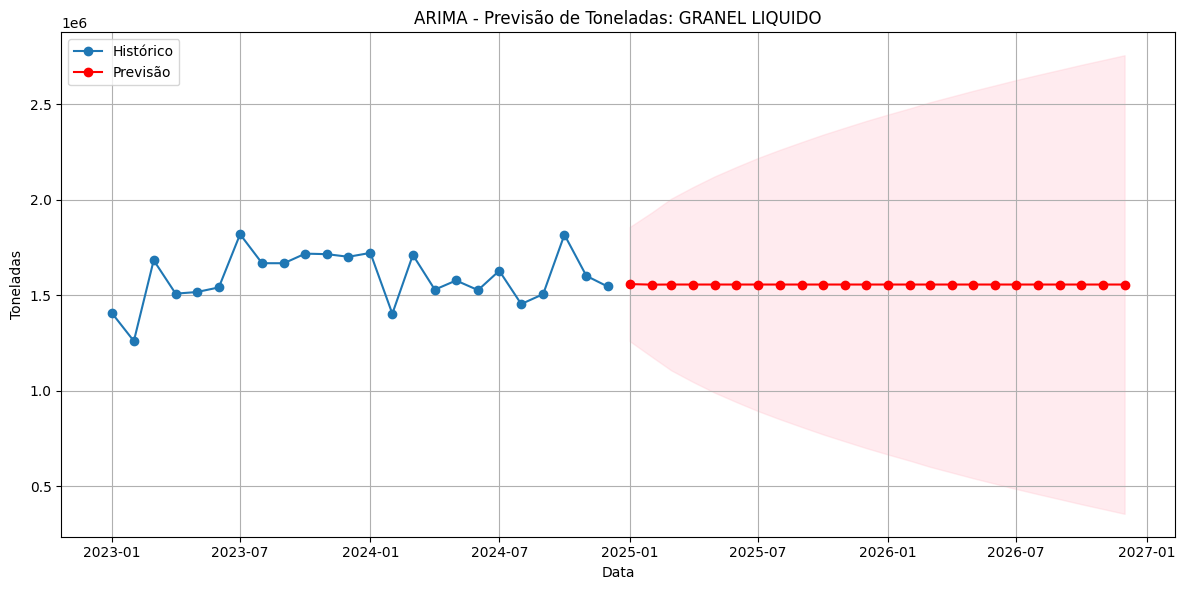

                               SARIMAX Results                                
Dep. Variable:              Toneladas   No. Observations:                   24
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -308.945
Date:                Tue, 10 Jun 2025   AIC                            621.891
Time:                        22:16:38   BIC                            624.162
Sample:                    01-01-2023   HQIC                           622.462
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2276      0.085     -2.680      0.007      -0.394      -0.061
sigma2      2.318e+10   1.42e-13   1.63e+23      0.000    2.32e+10    2.32e+10
Ljung-Box (L1) (Q):                   1.41   Jarque-

In [ ]:
# Ajustar modelo ARIMA
modelo = ARIMA(ts, order=(1,1,0))  # ordem (p,d,q) — pode ajustar depois
resultado = modelo.fit()

# Previsão para os próximos 6 meses
n_periods = 24
forecast = resultado.get_forecast(steps=n_periods)
forecast_index = pd.date_range(start=ts.index[-1] + pd.offsets.MonthBegin(1), periods=n_periods, freq='MS')
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Gráfico
plt.figure(figsize=(12,6))
plt.plot(ts, label='Histórico', marker='o')
plt.plot(forecast_index, forecast_values, label='Previsão', marker='o', color='red')

# Intervalo de confiança
plt.fill_between(forecast_index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3)

plt.title(f'ARIMA - Previsão de Toneladas: {carga}')
plt.xlabel('Data')
plt.ylabel('Toneladas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Exibir resumo do modelo
print(resultado.summary())

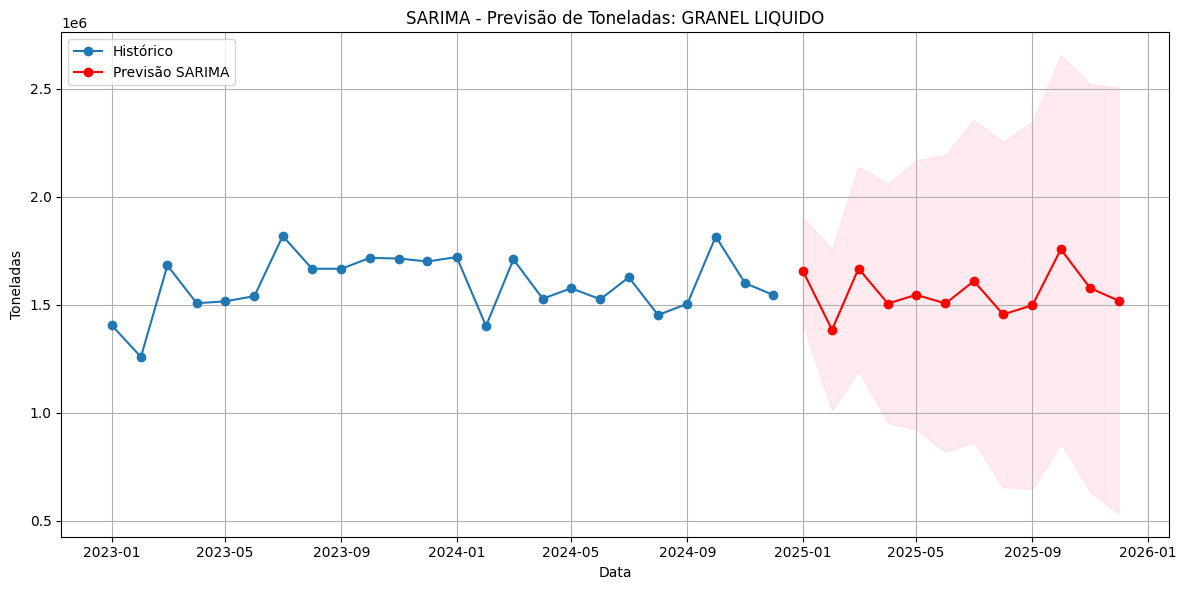

                                     SARIMAX Results                                      
Dep. Variable:                          Toneladas   No. Observations:                   24
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -144.334
Date:                            Tue, 10 Jun 2025   AIC                            298.668
Time:                                    22:17:55   BIC                            300.658
Sample:                                01-01-2023   HQIC                           297.414
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1866      4.413      0.042      0.966      -8.463       8.836
ma.L1         -0.0465      4.145   

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX # Importar SARIMAX
import warnings

warnings.filterwarnings('ignore')

# Carregar as abas de 2023 e 2024
file_path = '/content/drive/MyDrive/ML II/APS_DADOS_ANUAIS.xlsx'
xls = pd.ExcelFile(file_path)

sheets_to_load = ['2023', '2024']
dfs = [pd.read_excel(xls, sheet_name=sheet) for sheet in sheets_to_load]

# Concatenar as abas
df_combined = pd.concat(dfs, ignore_index=True)

# Selecionar apenas as colunas necessárias
df_selected = df_combined[['naturezacarga', 'Ano', 'Mês', 'Toneladas']]

# Agrupar por naturezacarga, Ano e Mês e somar as Toneladas
df_grouped = df_selected.groupby(['naturezacarga', 'Ano', 'Mês']).agg({'Toneladas': 'sum'}).reset_index()

# Criar coluna Data
df_grouped['Data'] = pd.to_datetime({
    'year': df_grouped['Ano'],
    'month': df_grouped['Mês'],
    'day': 1
}, errors='coerce')

carga = 'GRANEL LIQUIDO'
df_carga = df_grouped[df_grouped['naturezacarga'] == carga].copy()

# Transformar data como indice da carga
df_carga = df_carga.set_index('Data').sort_index()

# Selecionar a coluna toneladas
ts = df_carga['Toneladas']

# --- Ajustar modelo SARIMA ---
# Parâmetros não sazonais (p,d,q) - Exemplo: (1,1,1)
order = (1, 1, 1)
# Parâmetros sazonais (P,D,Q,S) - Exemplo: (1,1,1,12) para sazonalidade anual em dados mensais
# S = 12 para dados mensais, indicando um ciclo de 12 meses
seasonal_order = (1, 1, 1, 12)

# Ajustar modelo SARIMAX
modelo_sarima = SARIMAX(ts, order=order, seasonal_order=seasonal_order)
resultado_sarima = modelo_sarima.fit()

# Previsão para os próximos 12 meses
n_periods = 12
forecast_sarima = resultado_sarima.get_forecast(steps=n_periods)
forecast_index_sarima = pd.date_range(start=ts.index[-1] + pd.offsets.MonthBegin(1), periods=n_periods, freq='MS')
forecast_values_sarima = forecast_sarima.predicted_mean
forecast_ci_sarima = forecast_sarima.conf_int()

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Histórico', marker='o')
plt.plot(forecast_index_sarima, forecast_values_sarima, label='Previsão SARIMA', marker='o', color='red')

# Intervalo de confiança
plt.fill_between(forecast_index_sarima,
                 forecast_ci_sarima.iloc[:, 0],
                 forecast_ci_sarima.iloc[:, 1],
                 color='pink', alpha=0.3)

plt.title(f'SARIMA - Previsão de Toneladas: {carga}')
plt.xlabel('Data')
plt.ylabel('Toneladas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Exibir resumo do modelo SARIMA
print(resultado_sarima.summary())

Comparando os gráficos do Arima com o Sarima, observa-se que o Arima apresenta uma previsão linear enquanto o Sarima apresenta uma previsão não linear, o que indica uma sazonalidade nos dados, ou seja, o Sarima está capturando componentes dos dados que o Arima não consegue.

Há oscilações grandes de mês para mês, exemplo fevereiro baixa e julho e outubro alto. Isso descarta a hipótese de que a série seja constante ou aleatória. Como o Arima apenas projeta a média, ele não capturou bem esse comportamento. Os valores de Toneladas de Granel Liquido variam entre 1.2M e 1.8M  (ou um pouco mais). As quedas e subidas sazonais, embora presentes, mantem os valores dentro de uma faixa relativamente contida, sem quedas drásticas ou picos que dobrariam o que indica sazonalidade moderada.